# Code Completion Evaluation

This notebook implements various metrics to evaluate code completion quality and provides visualizations of the results.

## Setup

In [43]:
import json
from sacrebleu.metrics import CHRF
import pandas as pd
from Levenshtein import ratio
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## Load and Prepare Data

In [44]:
# Load data
with open("../data/dataset_with_labels.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"Loaded {len(df)} examples")
display(df.head())


Loaded 25 examples


file_name  \
0  abstract_model.py   
1  abstract_model.py   
2  lin_regression.py   
3  lin_regression.py   
4  lin_regression.py   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

## Implementation of Evaluation Metrics

In [45]:
def exact_match(completion: str, reference: str) -> float:
    return float(completion.strip() == reference.strip())

def chrf_score(completion: str, reference: str) -> float:
    chrf = CHRF(word_order=2)
    return chrf.sentence_score(completion, [reference]).score / 100.0

def token_overlap(completion: str, reference: str) -> float:
    comp_tokens = set(completion.strip().split())
    ref_tokens = set(reference.strip().split())
    
    if not ref_tokens:
        return 0.0
    
    intersection = comp_tokens.intersection(ref_tokens)
    return len(intersection) / len(ref_tokens)

def levenshtein_similarity(completion: str, reference: str) -> float:
    return ratio(completion.strip(), reference.strip())

def keyword_preservation(completion: str, reference: str) -> float:
    keywords = {'def', 'class', 'return', 'import', 'from', 'if', 'else', 'elif',
               'try', 'except', 'finally', 'raise', 'with', 'as', 'async', 'await'}
    
    comp_keywords = set(word for word in completion.split() if word in keywords)
    ref_keywords = set(word for word in reference.split() if word in keywords)
    
    if not ref_keywords:
        return 1.0
    
    preserved = comp_keywords.intersection(ref_keywords)
    return len(preserved) / len(ref_keywords)

## Calculate Metrics

In [46]:
# calculate metrics for all examples
results = []
for _, row in df.iterrows():
    completion = row['model_completion']
    reference = row['middle']
    
    metrics = {
        'file_name': row['file_name'],
        'exact_match': exact_match(completion, reference),
        'chrf': chrf_score(completion, reference),
        'token_overlap': token_overlap(completion, reference),
        'levenshtein': levenshtein_similarity(completion, reference),
        'keyword_preservation': keyword_preservation(completion, reference)
    }
    
    if 'Label' in row:
        metrics['manual_label'] = row['Label']
        
        label_map = {'correct': 1.0, 'partial': 0.5, 'incorrect': 0.0}
        metrics['manual_score'] = label_map.get(row['Label'])
    
    results.append(metrics)

results_df = pd.DataFrame(results)

## Analysis and Visualization

Summary stats:


,exact_match,chrf,token_overlap,levenshtein,keyword_preservation,manual_score
count,25.0,25.000000,25.000000,25.000000,25.000000,25.00
mean,0.0,0.415132,0.416095,0.477810,0.860000,0.34
std,0.0,0.295187,0.407776,0.172450,0.339116,0.45
min,0.0,0.055079,0.000000,0.219512,0.000000,0.00
25%,0.0,0.189054,0.000000,0.355556,1.000000,0.00
50%,0.0,0.275704,0.333333,0.441860,1.000000,0.00
75%,0.0,0.710505,0.750000,0.601942,1.000000,1.00
max,0.0,0.943080,1.000000,0.964706,1.000000,1.00


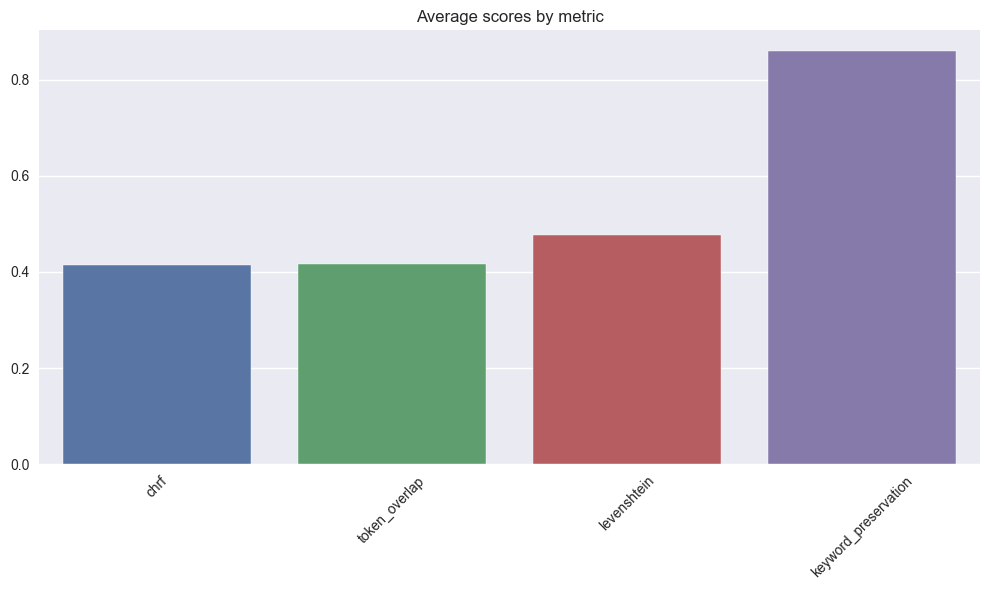

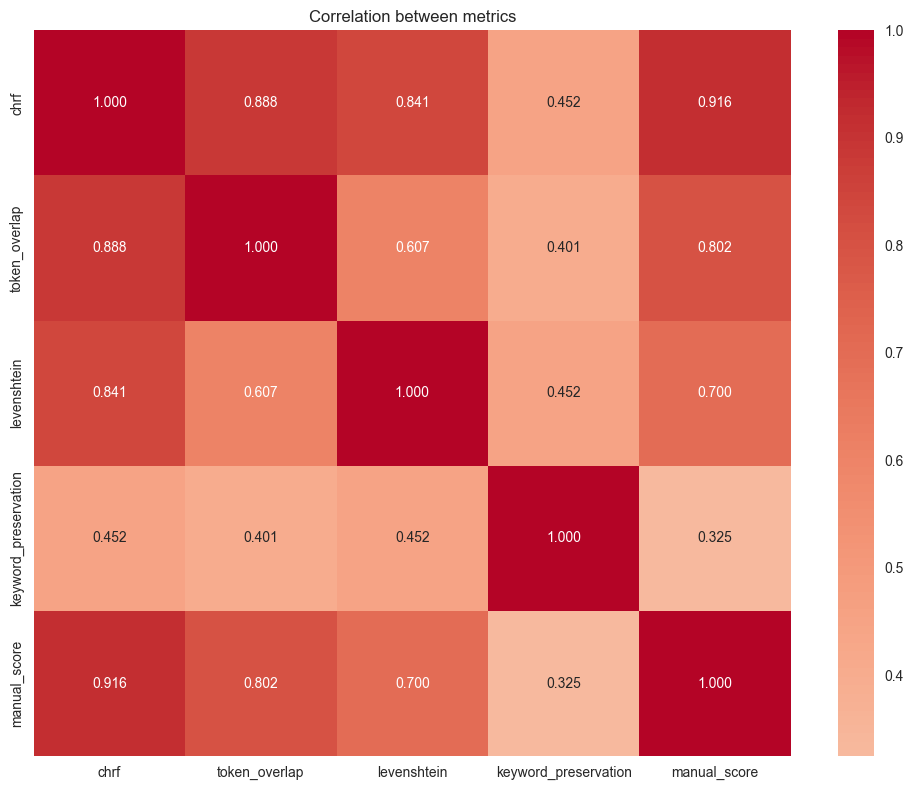

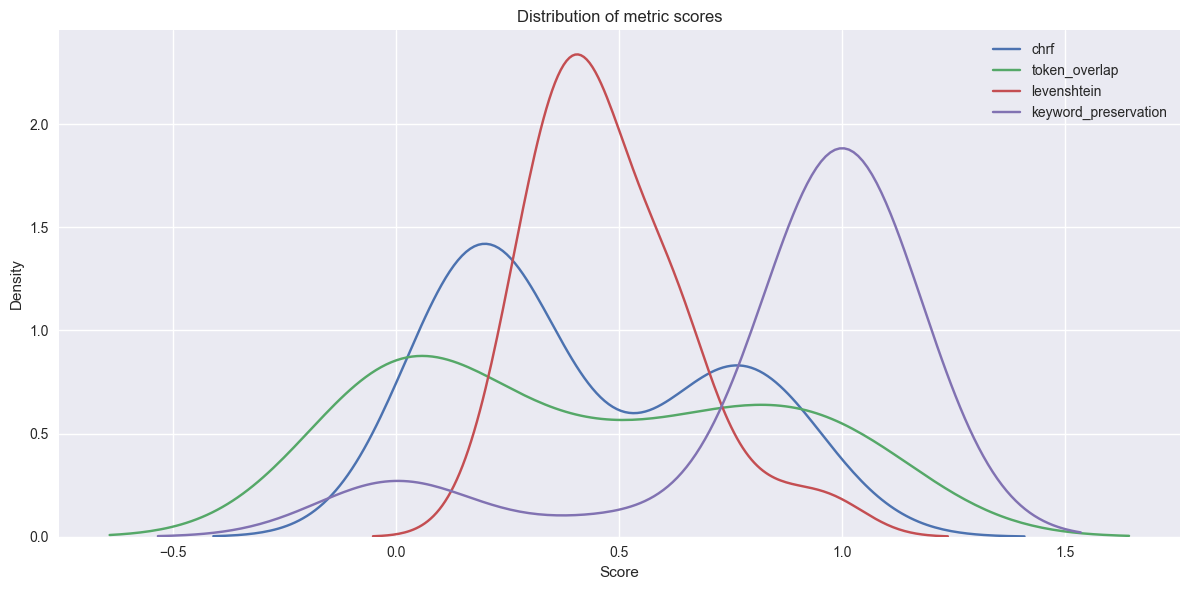

In [51]:
plt.style.use('seaborn')

print("Summary stats:")
display(results_df.describe())

plt.figure(figsize=(10, 6))
metrics = ['chrf', 'token_overlap', 'levenshtein', 'keyword_preservation'] # Excluded exact_match
avg_scores = results_df[metrics].mean()
sns.barplot(x=avg_scores.index, y=avg_scores.values)
plt.title('Average scores by metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# correlation heatmap
if 'manual_score' in results_df.columns:
    plt.figure(figsize=(10, 8))
    metrics_with_manual = metrics + ['manual_score']
    corr = results_df[metrics_with_manual].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.3f')
    plt.title('Correlation between metrics')
    plt.tight_layout()
    plt.show()

# distributions
plt.figure(figsize=(12, 6))
for metric in metrics:
    sns.kdeplot(data=results_df[metric], label=metric)
plt.title('Distribution of metric scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Full analysis

In [48]:
print("Examples with metrics:")
for idx, row in results_df.iterrows():
    print("\nExample", idx + 1)
    print(f"File: {row['file_name']}")
    print("\nMetrics:")
    for metric in metrics:
        print(f"{metric:20}: {row[metric]:.3f}")
    if 'manual_label' in row:
        print(f"{'manual_label':20}: {row['manual_label']}")
    print("-" * 80)

Examples with metrics:

Example 1
File: abstract_model.py

Metrics:
chrf                : 0.646
token_overlap       : 1.000
levenshtein         : 0.432
keyword_preservation: 1.000
manual_label        : partial
--------------------------------------------------------------------------------

Example 2
File: abstract_model.py

Metrics:
chrf                : 0.099
token_overlap       : 0.000
levenshtein         : 0.320
keyword_preservation: 0.000
manual_label        : incorrect
--------------------------------------------------------------------------------

Example 3
File: lin_regression.py

Metrics:
chrf                : 0.154
token_overlap       : 0.000
levenshtein         : 0.323
keyword_preservation: 1.000
manual_label        : incorrect
--------------------------------------------------------------------------------

Example 4
File: lin_regression.py

Metrics:
chrf                : 0.214
token_overlap       : 0.000
levenshtein         : 0.391
keyword_preservation: 1.000
manual_label